## ANN Classification - torch

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

from torch.utils.data import TensorDataset, DataLoader

In [16]:
# Load dataset
data = pd.read_csv("fraudTest.csv", index_col=0)

# Quick check
data.head()


,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,2020-06-21 12:14:25,2291163933867244,fraud_Kirlin and Sons,personal_care,2.86,Jeff,Elliott,M,351 Darlene Green,Columbia,...,33.9659,-80.9355,333497,Mechanical engineer,1968-03-19,2da90c7d74bd46a0caf3777415b3ebd3,1371816865,33.986391,-81.200714,0
1,2020-06-21 12:14:33,3573030041201292,fraud_Sporer-Keebler,personal_care,29.84,Joanne,Williams,F,3638 Marsh Union,Altonah,...,40.3207,-110.4360,302,"Sales professional, IT",1990-01-17,324cc204407e99f51b0d6ca0055005e7,1371816873,39.450498,-109.960431,0
2,2020-06-21 12:14:53,3598215285024754,"fraud_Swaniawski, Nitzsche and Welch",health_fitness,41.28,Ashley,Lopez,F,9333 Valentine Point,Bellmore,...,40.6729,-73.5365,34496,"Librarian, public",1970-10-21,c81755dbbbea9d5c77f094348a7579be,1371816893,40.495810,-74.196111,0
3,2020-06-21 12:15:15,3591919803438423,fraud_Haley Group,misc_pos,60.05,Brian,Williams,M,32941 Krystal Mill Apt. 552,Titusville,...,28.5697,-80.8191,54767,Set designer,1987-07-25,2159175b9efe66dc301f149d3d5abf8c,1371816915,28.812398,-80.883061,0
4,2020-06-21 12:15:17,3526826139003047,fraud_Johnston-Casper,travel,3.19,Nathan,Massey,M,5783 Evan Roads Apt. 465,Falmouth,...,44.2529,-85.0170,1126,Furniture designer,1955-07-06,57ff021bd3f328f8738bb535c302a31b,1371816917,44.959148,-85.884734,0


In [17]:
# Drop columns with too many categories or not useful
data = data.drop(columns=[
    "cc_num", "first", "last", "street",
    "trans_num", "trans_date_trans_time",
    "job", "merchant", "zip", "dob", "city"
])


In [18]:
# Label encode gender

gender_le = LabelEncoder()
data['gender'] = gender_le.fit_transform(data['gender'])

# One-hot encode 'category' and 'state'

ohe = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')
cat_features = ['category', 'state']
ohe_encoded = ohe.fit_transform(data[cat_features])

# Convert back to DataFrame with proper column names

ohe_df = pd.DataFrame(ohe_encoded,
                      columns=ohe.get_feature_names_out(cat_features),
                      index=data.index)

# Concatenate back to dataset and drop originals

df = pd.concat([data.drop(columns=cat_features), ohe_df],
               axis = 1)

In [19]:
X = df.drop(columns=['is_fraud'])
y = df['is_fraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

num_cols = ['amt','lat','long','city_pop','unix_time','merch_lat','merch_long']

scaler = StandardScaler()

X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

In [20]:
device = torch.device('cpu')

X_train_torch = torch.tensor(X_train.values, dtype=torch.float32)
X_test_torch = torch.tensor(X_test.values, dtype=torch.float32)
y_train_torch = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
y_test_torch = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

batch_size = 256

train_ds = TensorDataset(X_train_torch, y_train_torch)
test_ds = TensorDataset(X_test_torch, y_test_torch)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

In [21]:
class FraudNet(nn.Module):

    def __init__(self, input_dim):

        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.LeakyReLU(0.01),
            nn.Dropout(0.3),
            nn.Linear(128,64),
            nn.LeakyReLU(0.01),
            nn.Dropout(0.3),
            nn.Linear(64,1),
            nn.Sigmoid()
        )

    def forward(self, x):

        return self.net(x)
    
inp_dim = X_train_torch.shape[1]

model = FraudNet(input_dim=inp_dim)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


In [22]:
num_epochs = 20
train_losses = []
val_losses = []

for epoch in range(num_epochs):

    model.train()
    train_loss_sum = 0

    for xb_train, yb_train in train_loader:

        optimizer.zero_grad()
        pred_train = model(xb_train)
        loss_train = criterion(pred_train, yb_train)
        loss_train.backward()
        optimizer.step()
        train_loss_sum += loss_train.item() * xb_train.size(0)

    epoch_train_loss = train_loss_sum / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)
    model.eval()
    val_loss_sum = 0

    with torch.no_grad():
        for xb_val, yb_val in val_loader:
            pred_val = model(xb_val)
            loss_val = criterion(pred_val, yb_val)
            val_loss_sum += loss_val.item() * xb_val.size(0)

    epoch_val_loss = val_loss_sum / len(val_loader.dataset)
    val_losses.append(epoch_val_loss)

    print(f"Epoch {epoch+1} / {num_epochs} | Train {epoch_train_loss: .4f} | Val {epoch_val_loss: .6f}")

Epoch 1 / 20 | Train  0.0269 | Val  0.015015
Epoch 2 / 20 | Train  0.0146 | Val  0.012587
Epoch 3 / 20 | Train  0.0123 | Val  0.010962
Epoch 4 / 20 | Train  0.0115 | Val  0.010428
Epoch 5 / 20 | Train  0.0108 | Val  0.010674
Epoch 6 / 20 | Train  0.0105 | Val  0.010466
Epoch 7 / 20 | Train  0.0102 | Val  0.010043
Epoch 8 / 20 | Train  0.0098 | Val  0.009807
Epoch 9 / 20 | Train  0.0095 | Val  0.009092
Epoch 10 / 20 | Train  0.0091 | Val  0.008868
Epoch 11 / 20 | Train  0.0089 | Val  0.009019
Epoch 12 / 20 | Train  0.0088 | Val  0.009448
Epoch 13 / 20 | Train  0.0084 | Val  0.007993
Epoch 14 / 20 | Train  0.0084 | Val  0.008068
Epoch 15 / 20 | Train  0.0079 | Val  0.007805
Epoch 16 / 20 | Train  0.0079 | Val  0.007808
Epoch 17 / 20 | Train  0.0077 | Val  0.007961
Epoch 18 / 20 | Train  0.0076 | Val  0.007782
Epoch 19 / 20 | Train  0.0075 | Val  0.007590
Epoch 20 / 20 | Train  0.0074 | Val  0.007033


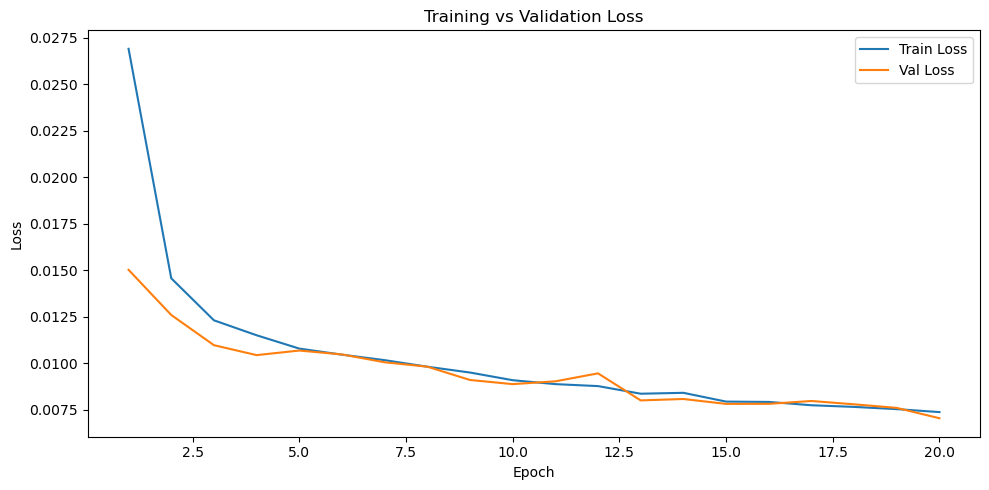

In [23]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.tight_layout()
plt.show()

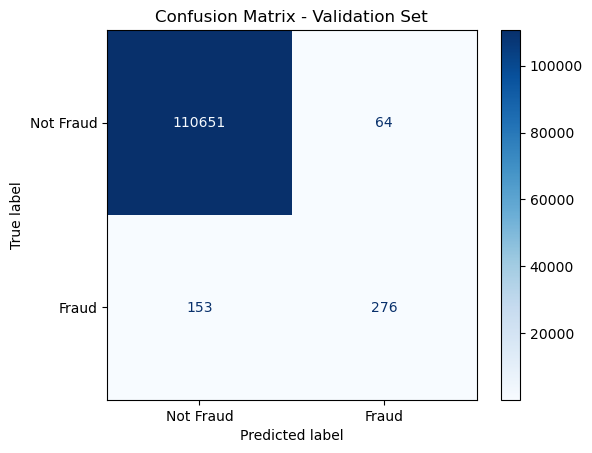

              precision    recall  f1-score   support

   Not Fraud       1.00      1.00      1.00    110715
       Fraud       0.81      0.64      0.72       429

    accuracy                           1.00    111144
   macro avg       0.91      0.82      0.86    111144
weighted avg       1.00      1.00      1.00    111144



In [24]:
model.eval()
with torch.no_grad():
    y_pred_probs = model(X_test_torch)
    y_pred = (y_pred_probs >= 0.5).int().squeeze().numpy()
    y_true = y_test_torch.squeeze().int().numpy()

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Fraud', 'Fraud'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix - Validation Set')
plt.show()

print(classification_report(y_true, y_pred, target_names=['Not Fraud', 'Fraud']))